# 5 Predicting Categories

## 5.0 Imports

### 5.0.1 Libraries

In [76]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [77]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

In [ ]:
import tensorflow as tf
%load_ext tensorboard
import tensorflow.contrib.keras as keras
from tensorflow.keras import layers

In [79]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.mode.chained_assignment = None

### 5.0.2 Train and test sets

In [425]:
X_train = pd.read_csv("train_and_test_sets/X_train.csv")
Y_train = pd.read_csv("train_and_test_sets/Y_train.csv")
X_train_weighted = pd.read_csv("train_and_test_sets/X_train_weighted.csv")
Y_train_weighted = pd.read_csv("train_and_test_sets/Y_train_weighted.csv")

In [426]:
X_test = pd.read_csv("train_and_test_sets/X_test.csv")
Y_test = pd.read_csv("train_and_test_sets/Y_test.csv")
X_test_weighted = pd.read_csv("train_and_test_sets/X_test_weighted.csv")
Y_test_weighted = pd.read_csv("train_and_test_sets/Y_test_weighted.csv")

## 5.1 Preprocessing

### 5.1.1 Merging identical categories

In [427]:
response_sets = [Y_train, Y_train_weighted, Y_test, Y_test_weighted]

In [428]:
categories_to_merge = [
    ('ARTS', 'ARTS & CULTURE'),
    ('CULTURE & ARTS', 'ARTS & CULTURE'),
    ('THE WORLDPOST', 'WORLDPOST'),
    ('PARENTS', 'PARENTING'),
    ('STYLE', 'STYLE & BEAUTY')
]

In [429]:
for tup in categories_to_merge:
    for dataset in response_sets:
        dataset.replace(tup[0], tup[1], inplace = True)

### 5.1.2 Data imbalance

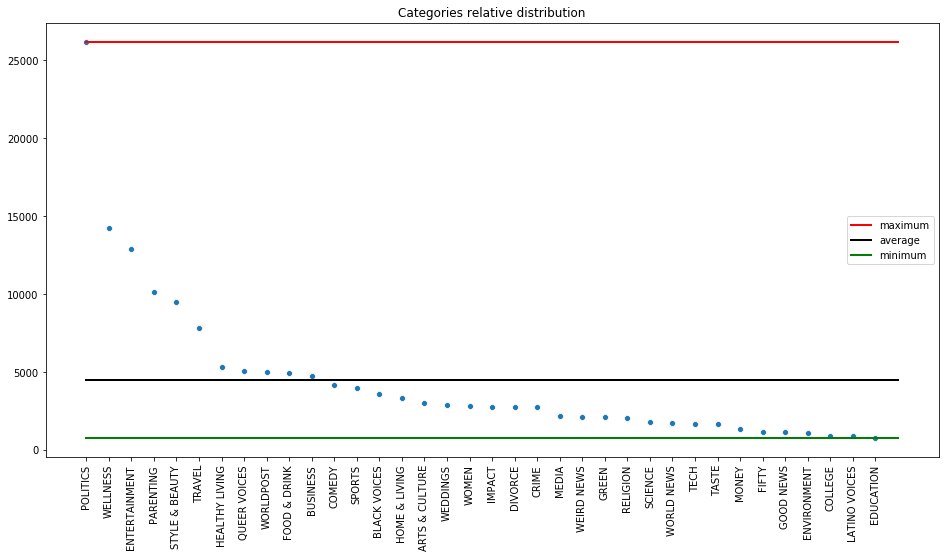

In [430]:
categories, counts = zip(*Counter(Y_train.categories).most_common())

plt.figure(figsize = (16, 8));
plt.xticks(rotation = 90);
g = sns.scatterplot(categories, counts).set_title("Categories relative distribution");
plt.plot([0, len(counts)], [np.max(counts), np.max(counts)], linewidth = 2, color = 'red');
plt.plot([0, len(counts)], [np.mean(counts), np.mean(counts)], linewidth = 2, color = 'black');
plt.plot([0, len(counts)], [np.min(counts), np.min(counts)], linewidth = 2, color = 'green');
plt.legend(['maximum', 'average', 'minimum']);

In [431]:
benchmark_unbalanced = round(max(counts) / sum(counts) * 100, 2)
benchmark_balanced = round(1 / len(counts) * 100, 2)
print('Alyways predicting the biggest category would yield an accuracy of', benchmark_unbalanced, '%.')
print('The benchmark for a balanced data set would yield an accuracy of', benchmark_balanced, '%.')
oversampling_add = round((max(counts) * len(counts) - sum(counts)) / sum(counts) * 100)
undersampling_sub = round((sum(counts) - min(counts) * len(counts)) / sum(counts) * 100)
print('Full oversampling would generate an additional', oversampling_add, '% of data.')
print('Full undersampling would remove', undersampling_sub, '% of data.')

Alyways predicting the biggest category would yield an accuracy of 16.31 %.
The benchmark for a balanced data set would yield an accuracy of 2.78 %.
Full oversampling would generate an additional 487 % of data.
Full undersampling would remove 82 % of data.


## 5.2 Classifiers

### 5.2.1 Default parameters

In [432]:
X_Y_train_sets = [
    ('headlines', X_train, Y_train),
    ('headlines_weighted', X_train_weighted, Y_train_weighted)
]

In [433]:
sample_categories = list(categories[-10:])
sample_indices = [
    index for index, category in enumerate(Y_train.categories.tolist()) if category in sample_categories
]

sample_indices_weighted = [
    index for index, category in enumerate(Y_train_weighted.categories.tolist()) if category in sample_categories
]

X_small = X_train.iloc[sample_indices]
Y_small = Y_train.iloc[sample_indices]

X_small_weighted = X_train_weighted.iloc[sample_indices_weighted]
Y_small_weighted = Y_train_weighted.iloc[sample_indices_weighted]

X_small_scaled = StandardScaler().fit_transform(X_small)
X_small_weighted_scaled = StandardScaler().fit_transform(X_small_weighted)

In [435]:
X_Y_train_sets_small = [
    ('headlines_small', X_small, Y_small),
    ('headlines_weighted_small', X_small_weighted, Y_small_weighted),
    ('headlines_small_scaled', X_small_scaled, Y_small),
    ('headlines_weighted_small_scaled', X_small_weighted_scaled, Y_small_weighted)
]

In [ ]:
classifiers = [
    ('RFC', RandomForestClassifier(random_state = 0, n_estimators = 50, n_jobs = -1)),
    ('KNN', KNeighborsClassifier(n_jobs = -1)),
    ('SVC', LinearSVC())
]

cv_accuracies = {}
for classifier in classifiers:
    for sets in X_Y_train_sets_small:
        cv_accuracies[(classifier[0], sets[0])] = cross_val_score(
            classifier[1], sets[1], sets[2].values.ravel(), cv = 5, n_jobs = -1, verbose = 5
        )

In [466]:
cv_accuracies_list = [(tup[0][0], tup[0][1][10:], round(np.mean(tup[1]), 4)) for tup in list(cv_accuracies.items())]
cv_accuracies_df = pd.DataFrame(
    cv_accuracies_list, columns = ['classifier', 'predictor', 'accuracy']
).pivot('classifier', 'predictor', 'accuracy')
cv_accuracies_df

predictor,small,small_scaled,weighted_small,weighted_small_scaled
classifier,,,,
KNN,0.3524,0.3536,0.7223,0.7233
RFC,0.4117,0.4128,0.7352,0.7388
SVC,0.5056,0.5331,0.1561,0.7251


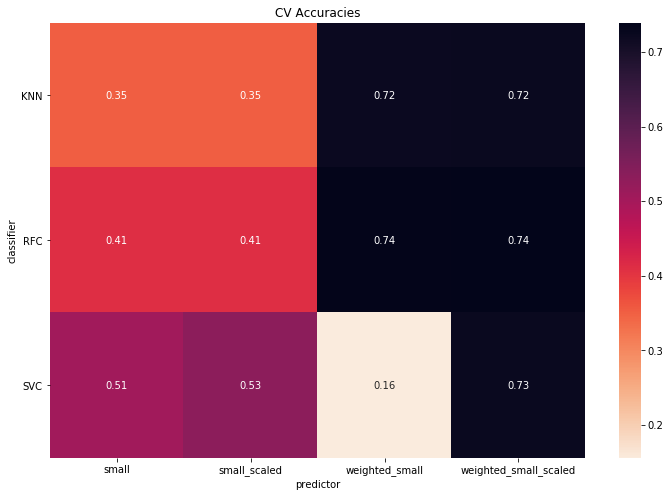

In [478]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cv_accuracies_df, annot=True, cmap = sns.cm.rocket_r);
ax.yaxis.set_tick_params(rotation = 0);
plt.title('CV Accuracies');

### 5.2.2 Model hyperparameter tuning

#### 5.2.2.1 Random Forest

In [ ]:
random_forest_pipe = Pipeline(
    [('rf', RandomForestClassifier(random_state = 0, n_estimators = 100, n_jobs = -1))]
)

rf_param_grid = {
    'rf__max_depth': np.arange(2, 25, 3),
    'rf__max_features' : [2 ** power for power in list(range(1, 9))]
}

random_forest_grid_search = GridSearchCV(
    random_forest_pipe, param_grid = rf_param_grid, return_train_score = True,
    scoring = 'accuracy', n_jobs = -1, verbose = 5, cv = 5
)

_ = random_forest_grid_search.fit(X_small_weighted, Y_small_weighted.values.ravel());

In [504]:
rf_grid_search_cv_results_ = pd.DataFrame(random_forest_grid_search.cv_results_)
rf_gs_best_accuracy = round(random_forest_grid_search.best_score_ * 100, 2)
rf_accuracy_increase = round(rf_gs_best_accuracy - cv_accuracies_df['weighted_small']['RFC'] * 100, 2)
print('Random Forest grid search best score:', rf_gs_best_accuracy, '%.')
print('Corresponding model parameters:', random_forest_grid_search.best_params_)
print('The accuracy increased', rf_accuracy_increase, '% due to grid search.')

Random Forest grid search best score: 74.03 %.
Corresponding model parameters: {'rf__max_depth': 23, 'rf__max_features': 128}
The accuracy incresed 0.51 % due to grid search.


#### 5.2.2.2 K-Nearest Neighbors

In [ ]:
knn_pipe = Pipeline(
    [('knn', KNeighborsClassifier(n_jobs = -1))]
)

knn_param_grid = {
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 3],
    'knn__n_neighbors': [1, 3, 5]
}

knn_grid_search = GridSearchCV(
    knn_pipe, param_grid = knn_param_grid, return_train_score = True,
    scoring = 'accuracy', n_jobs = -1, verbose = 5, cv = 5
)

_ = knn_grid_search.fit(X_small_weighted, Y_small_weighted.values.ravel());

In [505]:
knn_grid_search_cv_results_ = pd.DataFrame(knn_grid_search.cv_results_)
knn_gs_best_accuracy = round(knn_grid_search.best_score_ * 100, 2)
knn_accuracy_increase = round(knn_gs_best_accuracy - cv_accuracies_df['weighted_small']['KNN'] * 100, 2)
print('K-Nearest Neighbors grid search best score:', knn_gs_best_accuracy, '%.')
print('Corresponding model parameters:', knn_grid_search.best_params_)
print('The accuracy increased', knn_accuracy_increase, '% due to grid search.')

K-Nearest Neighbors grid search best score: 73.49 %.
Corresponding model parameters: {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
The accuracy incresed 1.26 % due to grid search.


#### 5.2.2.3 Suppor Vector Classifier

In [ ]:
svc_pipe = Pipeline(
    [('svc', LinearSVC())]
)

svc_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__dual': [True, False],
}

svc_grid_search = GridSearchCV(
    svc_pipe, param_grid = svc_param_grid, return_train_score = True,
    scoring = 'accuracy', n_jobs = -1, verbose = 5, cv = 5
)

_ = svc_grid_search.fit(X_small_weighted_scaled, Y_small_weighted.values.ravel());

In [506]:
svc_grid_search_cv_results_ = pd.DataFrame(svc_grid_search.cv_results_)
svc_gs_best_accuracy = round(svc_grid_search.best_score_ * 100, 2)
svc_accuracy_increase = round(svc_gs_best_accuracy - cv_accuracies_df['weighted_small_scaled']['SVC'] * 100, 2)
print('Support Vector Classifier grid search best score:', svc_gs_best_accuracy, '%.')
print('Corresponding model parameters:', svc_grid_search.best_params_)
print('The accuracy increased', svc_accuracy_increase, '% due to grid search.')

Support Vector Classifier grid search best score: 74.65 %.
Corresponding model parameters: {'svc__C': 10, 'svc__dual': False}
The accuracy incresed 2.14 % due to grid search.


### 5.3 Fitting the best models on the whole training set

In [ ]:
scaler = StandardScaler()
_ = scaler.fit(X_train_weighted);
X_train_weighted = scaler.transform(X_train_weighted)
X_test_weighted = scaler.transform(X_test_weighted)

In [ ]:
best_rfc_performances = cross_val_score(
    RandomForestClassifier(
        n_estimators = 100, max_depth = 23, max_features = 128, n_jobs = -1
    ), X_train_weighted, Y_train_weighted.values.ravel(), cv = 5, verbose = 5, n_jobs = -1
)

In [528]:
best_rfc_acc_rounded = round(np.mean(best_rfc_performances) * 100, 2)
print('RFC on the full train set with the best parameters has an accuracy of', best_rfc_acc_rounded, '%.')

RFC on the full train set with the best parameters has an accuracy of 70.15 %.


In [ ]:
best_knn_performances = cross_val_score(
    KNeighborsClassifier(
        n_neighbors = 5, p = 1, weights = 'distance', n_jobs = -1
    ), X_train_weighted, Y_train_weighted.values.ravel(), cv = 5, verbose = 5, n_jobs = -1
)

In [527]:
best_knn_acc_rounded = round(np.mean(best_knn_performances) * 100, 2)
print('KNN on the full train set with the best parameters has an accuracy of', best_knn_acc_rounded, '%.')

KNN on the full train set with the best parameters has an accuracy of 70.39 %.


In [ ]:
best_svc_performances = cross_val_score(
    LinearSVC(
        C = 100, dual = False
    ), X_train_weighted, Y_train_weighted.values.ravel(), cv = 5, verbose = 5, n_jobs = -1
)

In [ ]:
best_svc_acc_rounded = round(np.mean(best_svc_performances) * 100, 2)
print('SVC on the full train set with the best parameters has an accuracy of', best_svc_acc_rounded, '%.')

## 5.4 Neural net classifier

### 5.4.1 Preprocessing

In [560]:
input_layer_size = X_train_weighted.shape[1]
output_layer_size = len(set(np.unique(Y_train_weighted)))
hidden_layer_size = round(input_layer_size - (input_layer_size - output_layer_size) * 1/2)
hidden_layer_one_size = round(input_layer_size - (input_layer_size - output_layer_size) * 1/3)
hidden_layer_two_size = round(input_layer_size - (input_layer_size - output_layer_size) * 2/3)

In [561]:
Y_train_weighted_one_hot = OneHotEncoder().fit_transform(Y_train_weighted)
n_epochs = 50
epochs = np.arange(n_epochs)

### 5.4.2 No hidden layers

In [ ]:
neural_network_no_hl = tf.keras.models.Sequential([])
neural_network_no_hl.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
neural_network_no_hl.add(layers.Dense(output_layer_size, activation = 'softmax'))

neural_network_no_hl.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
neural_network_no_hl_history = neural_network_no_hl.fit(
    X_train_weighted, Y_train_weighted_one_hot, epochs = n_epochs, validation_split = 0.2
);

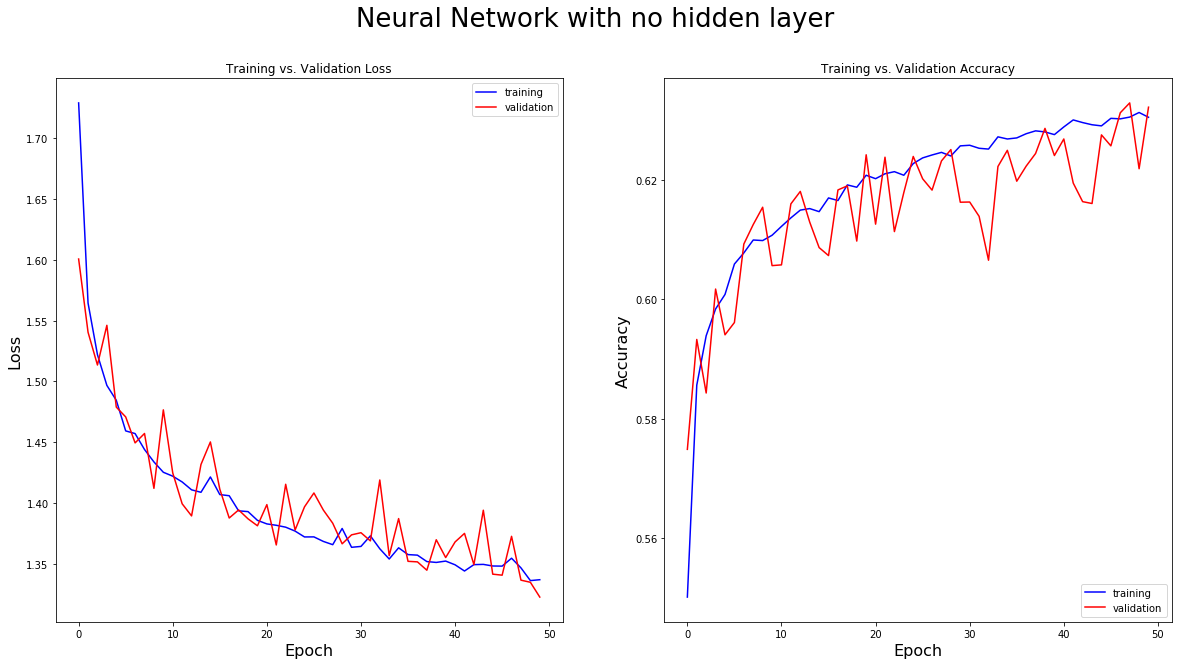

In [564]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'loss', 'val_loss', 'upper'), (1, 'Accuracy', 'acc', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Training vs. Validation ' + tup[1]);
    sns.lineplot(y = neural_network_no_hl_history.history[tup[2]], x = epochs, color = 'blue', ax = axes[tup[0]]);
    sns.lineplot(y = neural_network_no_hl_history.history[tup[3]], x = epochs, color = 'red', ax = axes[tup[0]]);
    axes[tup[0]].legend(['training', 'validation'], loc = tup[4] + ' right');

fig.suptitle('Neural Network with no hidden layer', fontsize = 26);

### 5.4.3 One hidden layer

In [ ]:
neural_network_one_hl = tf.keras.models.Sequential([])
neural_network_one_hl.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
neural_network_one_hl.add(layers.Dense(hidden_layer_size, activation = 'relu'))
neural_network_one_hl.add(layers.Dense(output_layer_size, activation = 'softmax'))

neural_network_one_hl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neural_network_one_hl_history = neural_network_one_hl.fit(
    X_train_weighted, Y_train_weighted_one_hot, epochs = n_epochs, validation_split = 0.2
);

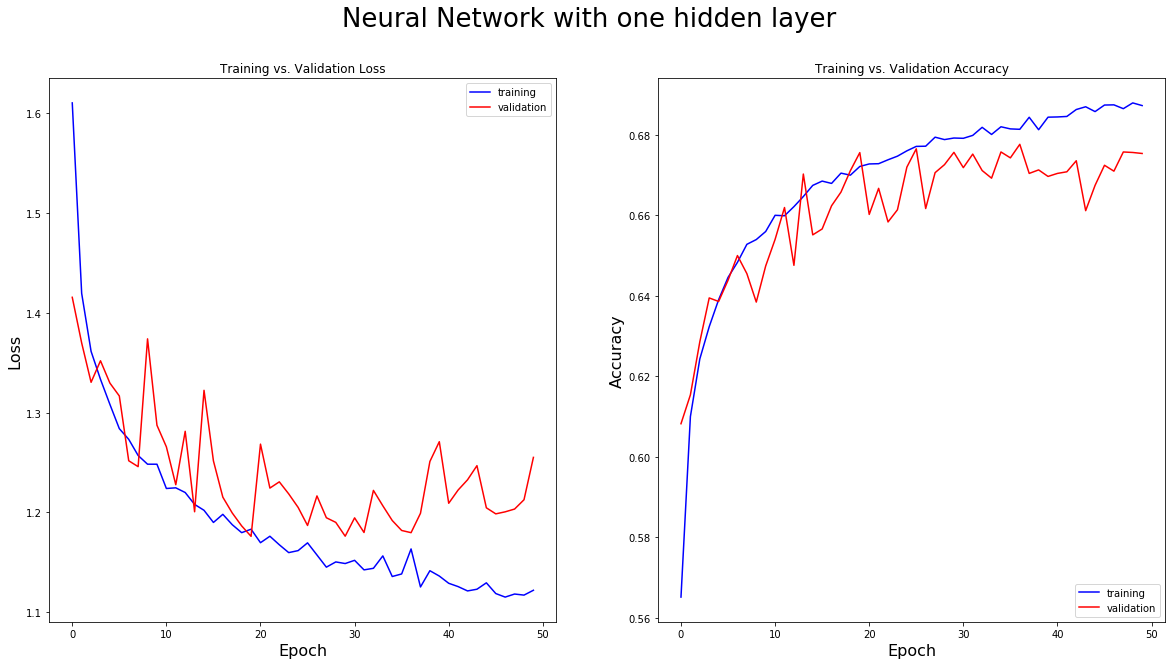

In [566]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'loss', 'val_loss', 'upper'), (1, 'Accuracy', 'acc', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Training vs. Validation ' + tup[1]);
    sns.lineplot(y = neural_network_one_hl_history.history[tup[2]], x = epochs, color = 'blue', ax = axes[tup[0]]);
    sns.lineplot(y = neural_network_one_hl_history.history[tup[3]], x = epochs, color = 'red', ax = axes[tup[0]]);
    axes[tup[0]].legend(['training', 'validation'], loc = tup[4] + ' right');

fig.suptitle('Neural Network with one hidden layer', fontsize = 26);

### 5.4.4 Two hidden layers

In [ ]:
neural_network_two_hl = tf.keras.models.Sequential([])
neural_network_two_hl.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
neural_network_two_hl.add(layers.Dense(hidden_layer_one_size, activation = 'relu'))
neural_network_two_hl.add(layers.Dense(hidden_layer_two_size, activation = 'relu'))
neural_network_two_hl.add(layers.Dense(output_layer_size, activation = 'softmax'))

neural_network_two_hl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
neural_network_two_hl_history = neural_network_two_hl.fit(
    X_train_weighted, Y_train_weighted_one_hot, epochs = n_epochs, validation_split = 0.2
);

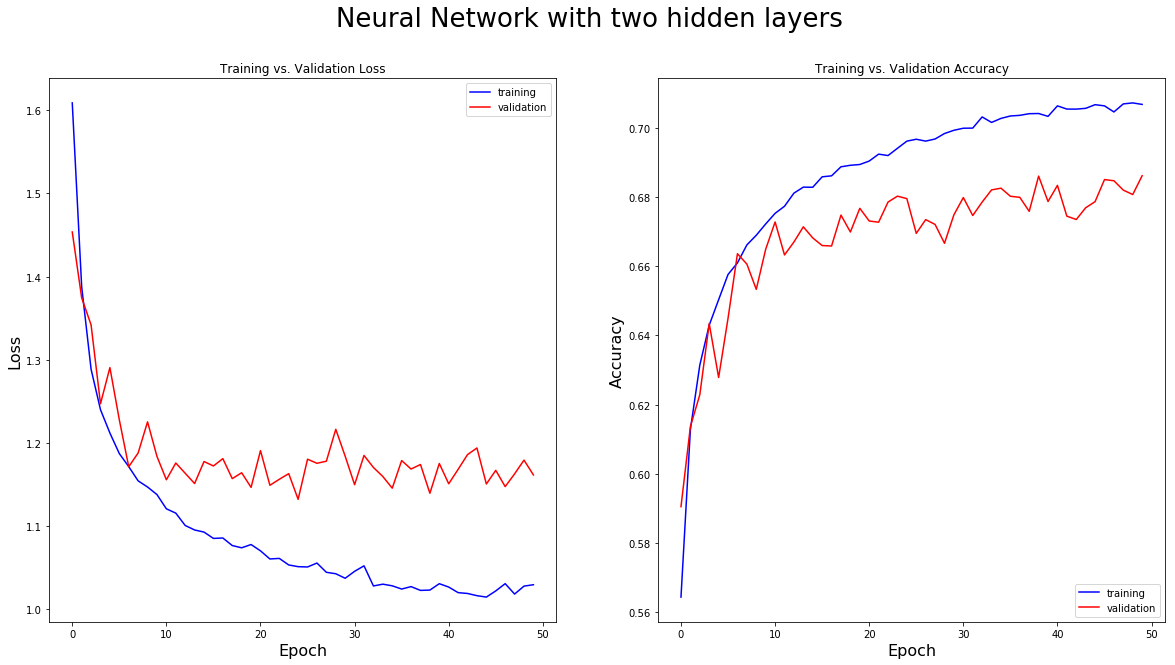

In [568]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'loss', 'val_loss', 'upper'), (1, 'Accuracy', 'acc', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Training vs. Validation ' + tup[1]);
    sns.lineplot(y = neural_network_two_hl_history.history[tup[2]], x = epochs, color = 'blue', ax = axes[tup[0]]);
    sns.lineplot(y = neural_network_two_hl_history.history[tup[3]], x = epochs, color = 'red', ax = axes[tup[0]]);
    axes[tup[0]].legend(['training', 'validation'], loc = tup[4] + ' right');

fig.suptitle('Neural Network with two hidden layers', fontsize = 26);

### 5.4.5 Network structure comparison

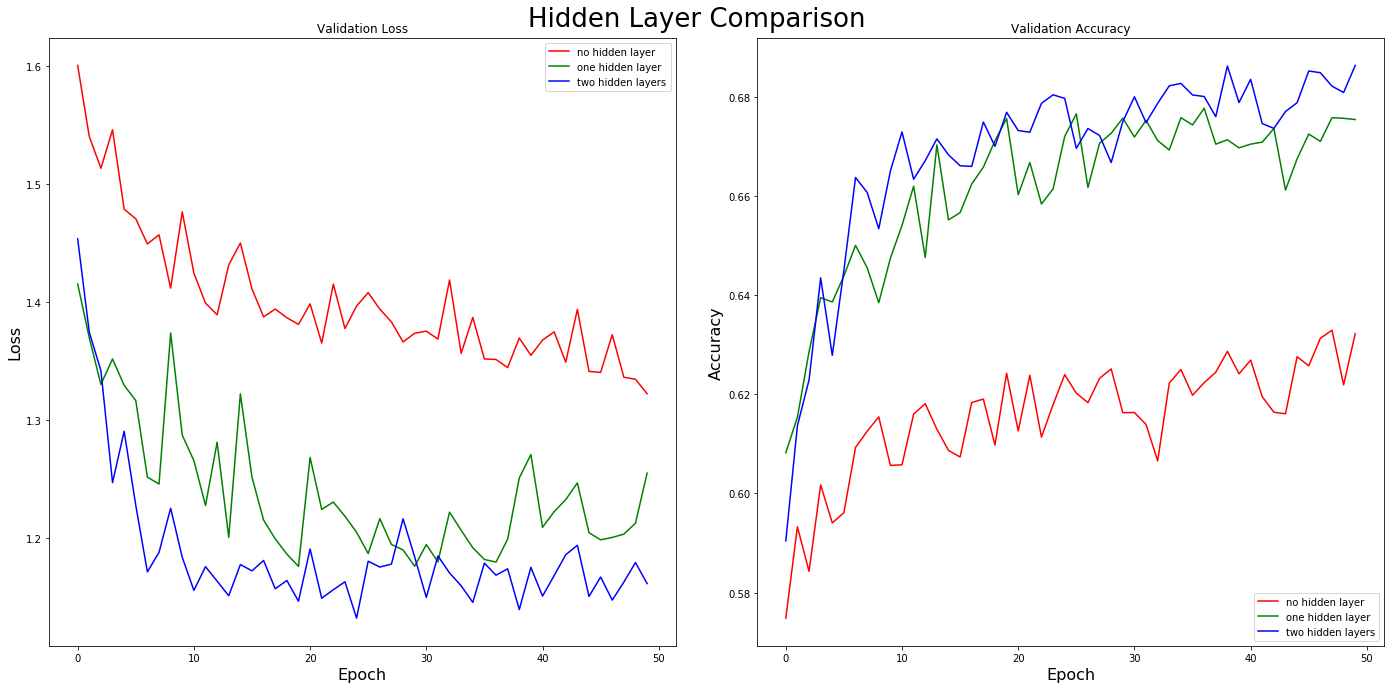

In [569]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'val_loss', 'upper'), (1, 'Accuracy', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Validation ' + tup[1]);
    for history_color in [(neural_network_no_hl_history, 'red'),
                          (neural_network_one_hl_history, 'green'),
                          (neural_network_two_hl_history, 'blue')]:
        sns.lineplot(y = history_color[0].history[tup[2]], x = epochs, color = history_color[1], ax = axes[tup[0]]);
    axes[tup[0]].legend(['no hidden layer', 'one hidden layer', 'two hidden layers'], loc = tup[3] + ' right');

fig.suptitle('Hidden Layer Comparison', fontsize = 26);
fig.tight_layout(pad = 3);

### 5.4.6 Optimizing the learning rate

In [ ]:
n_epochs, epochs = 70, np.arange(70)
learning_rates = [5e-3, 1e-3, 5e-4, 1e-4, 5e-05, 1e-05]
learning_rates_histories = []
for learning_rate in learning_rates:
    neural_network = tf.keras.models.Sequential([])
    neural_network.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
    neural_network.add(layers.Dense(hidden_layer_one_size, activation = 'relu'))
    neural_network.add(layers.Dense(hidden_layer_two_size, activation = 'relu'))
    neural_network.add(layers.Dense(output_layer_size, activation = 'softmax'))
    optimizer = keras.optimizers.Adam(lr = learning_rate)
    neural_network.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    neural_network_history = neural_network.fit(
        X_train_weighted, Y_train_weighted_one_hot, epochs = n_epochs, validation_split = 0.2
    );
    learning_rates_histories.append((learning_rate, neural_network_history))

lr_end = datetime.now()

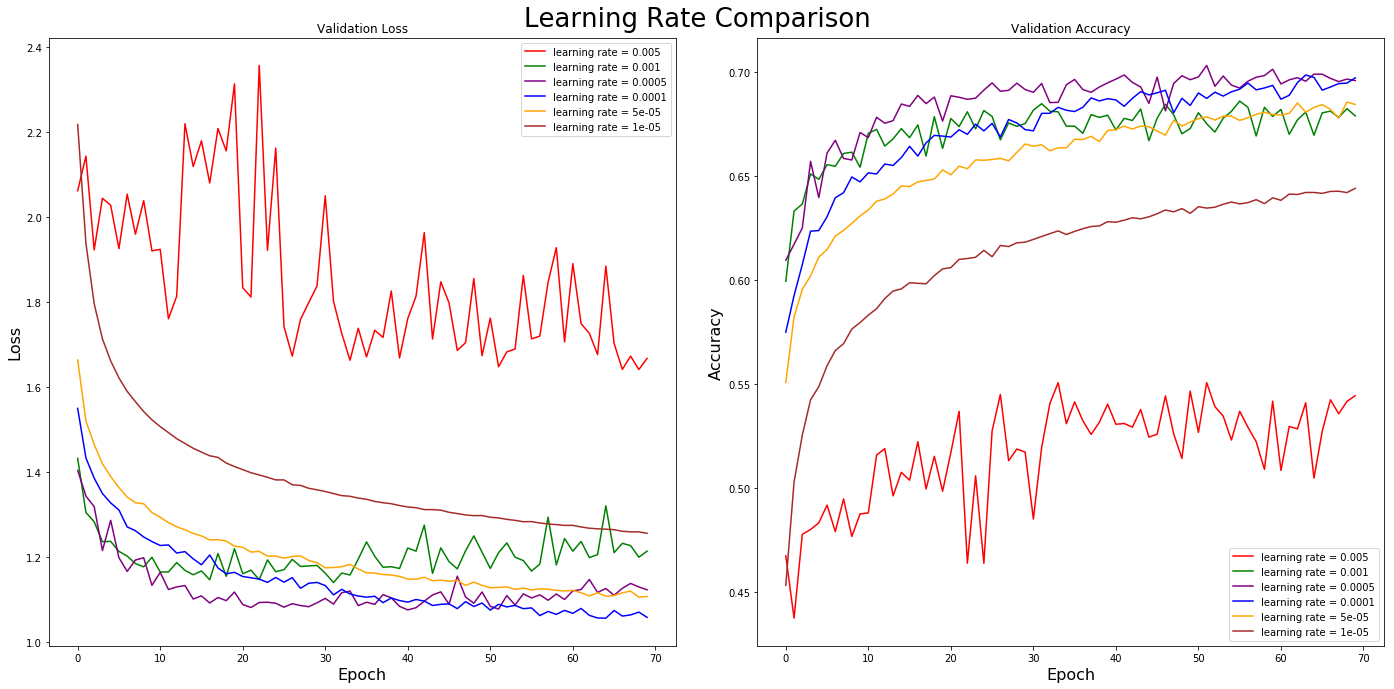

In [712]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'val_loss', 'upper'), (1, 'Accuracy', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Validation ' + tup[1]);
    for result in list(zip(learning_rates_histories, ['red', 'green', 'purple', 'blue', 'orange', 'brown'])):
        sns.lineplot(y = result[0][1].history[tup[2]], x = epochs, color = result[1], ax = axes[tup[0]]);
    axes[tup[0]].legend(['learning rate = ' + str(lr[0]) for lr in learning_rates_histories], loc = tup[3] + ' right');

fig.suptitle('Learning Rate Comparison', fontsize = 26);
fig.tight_layout(pad = 3);

### 5.4.7 Optimizing the batch size

In [ ]:
n_epochs, epochs = 50, np.arange(50)
batch_sizes = [2 ** i for i in list(range(3, 9))]
batch_sizes_histories = []
for batch_size in batch_sizes:
    neural_network = tf.keras.models.Sequential([])
    neural_network.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
    neural_network.add(layers.Dense(hidden_layer_one_size, activation = 'relu'))
    neural_network.add(layers.Dense(hidden_layer_two_size, activation = 'relu'))
    neural_network.add(layers.Dense(output_layer_size, activation = 'softmax'))
    optimizer = keras.optimizers.Adam(lr = 5e-4)
    neural_network.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    neural_network_history = neural_network.fit(
        X_train_weighted, Y_train_weighted_one_hot, batch_size = batch_size, epochs = n_epochs, validation_split = 0.2
    );
    batch_sizes_histories.append((batch_size, neural_network_history))

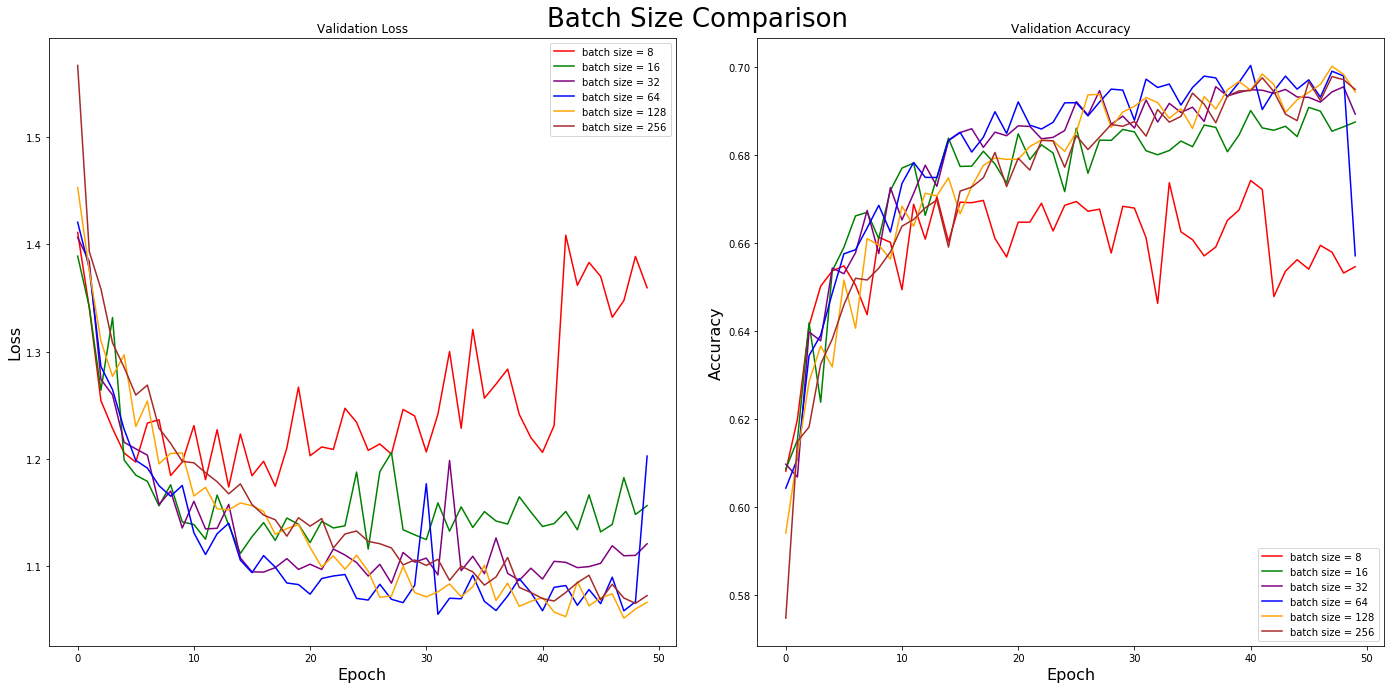

In [733]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'val_loss', 'upper'), (1, 'Accuracy', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Validation ' + tup[1]);
    for result in list(zip(batch_sizes_histories, ['red', 'green', 'purple', 'blue', 'orange', 'brown'])):
        sns.lineplot(y = result[0][1].history[tup[2]], x = epochs, color = result[1], ax = axes[tup[0]]);
    axes[tup[0]].legend(['batch size = ' + str(bs[0]) for bs in batch_sizes_histories], loc = tup[3] + ' right');

fig.suptitle('Batch Size Comparison', fontsize = 26);
fig.tight_layout(pad = 3);

### 5.4.8 Fitting the neural network using the best parameters

In [ ]:
mean_accs_lr = [np.mean(history[1].history['val_acc'][25:]) for history in learning_rates_histories]
best_lr = learning_rates_histories[mean_accs_lr.index(max(mean_accs_lr))][0]
mean_accs_bs = [np.mean(history[1].history['val_acc'][25:]) for history in batch_sizes_histories]
best_bs = batch_sizes_histories[mean_accs_bs.index(max(mean_accs_bs))][0]

In [ ]:
n_epochs = 100
best_neural_network = tf.keras.models.Sequential([])
best_neural_network.add(layers.Dense(input_layer_size, input_shape = (input_layer_size,)))
best_neural_network.add(layers.Dense(hidden_layer_one_size, activation = 'relu'))
best_neural_network.add(layers.Dense(hidden_layer_two_size, activation = 'relu'))
best_neural_network.add(layers.Dense(output_layer_size, activation = 'softmax'))
optimizer = keras.optimizers.Adam(lr = best_lr)
best_neural_network.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
best_neural_network_history = best_neural_network.fit(
    X_train_weighted, Y_train_weighted_one_hot, batch_size = best_bs, epochs = n_epochs, validation_split = 0.2
);

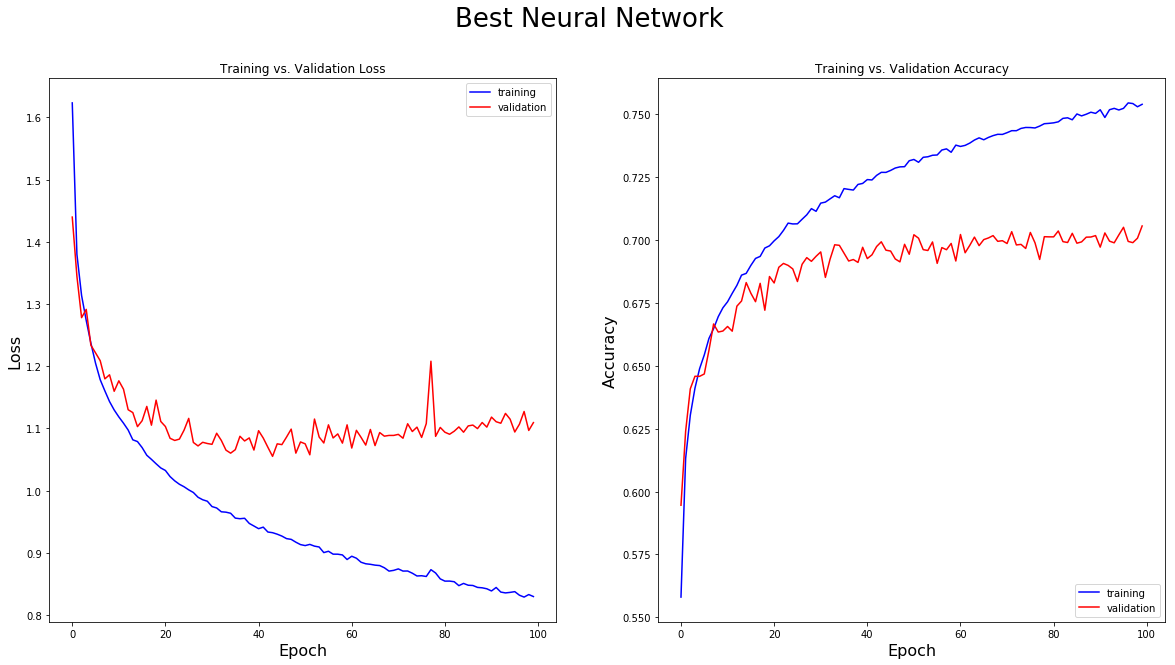

In [761]:
epochs = np.arange(n_epochs)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
for tup in [(0, 'Loss', 'loss', 'val_loss', 'upper'), (1, 'Accuracy', 'acc', 'val_acc', 'lower')]:
    axes[tup[0]].set_ylabel(tup[1], fontsize = 16);
    axes[tup[0]].set_xlabel('Epoch', fontsize = 16);
    axes[tup[0]].set_title('Training vs. Validation ' + tup[1]);
    sns.lineplot(y = best_neural_network_history.history[tup[2]], x = epochs, color = 'blue', ax = axes[tup[0]]);
    sns.lineplot(y = best_neural_network_history.history[tup[3]], x = epochs, color = 'red', ax = axes[tup[0]]);
    axes[tup[0]].legend(['training', 'validation'], loc = tup[4] + ' right');

fig.suptitle('Best Neural Network', fontsize = 26);

### 5.4.9 Prediction on the test set

In [762]:
actual_classes = LabelEncoder().fit_transform(Y_test_weighted.values.ravel())
predicted_classes = best_neural_network.predict_classes(X_test_weighted)
final_accuracy = round(accuracy_score(actual_classes, predicted_classes) * 100, 2)
print('The best Neural Network has a test accuracy of', final_accuracy, '%.')

The best Neural Network has a test accuracy of 70.61 %.
